In [1]:
import numpy as np
import GPy
import matplotlib.pyplot as plt
import scipy.stats as stats
import importlib

# Generate synthetic data 

In [2]:
N = 50

X = np.random.rand(N,1)*12
k1 = GPy.kern.RBF(1, variance=1, lengthscale=50)
K1 = k1.K(X)
f1 = np.random.multivariate_normal(np.zeros(N), K1).reshape(N,1)

k2 = GPy.kern.RBF(1, variance=1, lengthscale=5)
K2 = k2.K(X)
f2 = np.random.multivariate_normal(np.zeros(N), K2).reshape(N,1)

k3 = GPy.kern.RBF(1, variance=0.2, lengthscale=0.1)
K3 = k3.K(X)
f3 = np.random.multivariate_normal(np.zeros(N), K3).reshape(N,1)

f = np.hstack((f1, f2, f3))

W = np.array([[1, 0, 0], 
              [0, 1, 0], 
              [0, 0, 1]])

Y = np.dot(f,W) + np.random.randn(*f.shape) * 0.001

In [3]:
Ntrain = 35
Xtrain = X[:Ntrain,:]
Ytrain = Y[:Ntrain,:]
Xtest = X[Ntrain:,:]
Ytest = Y[Ntrain:,:]

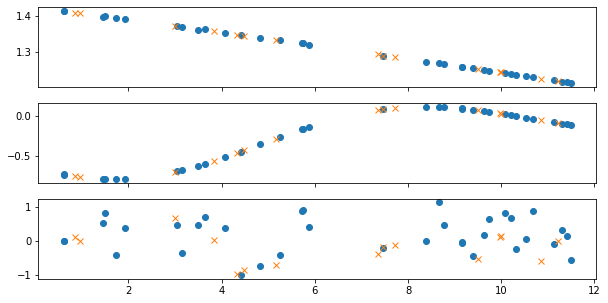

In [4]:
f, axes = plt.subplots(3, 1, sharex=True, figsize=(10, 5))
for i in range(3):
    axes[i].plot(Xtrain, Ytrain[:,i], linestyle='', marker='o')
    axes[i].plot(Xtest, Ytest[:,i], linestyle='', marker='x')

In [5]:
ones = np.ones(Xtest.shape[0])[:,np.newaxis]
newX = np.vstack([np.hstack([Xtest,ones*i]) for i in range(3)])
noise_dict = {'output_index': newX[:,[-1]].astype(int)}

In [6]:
Xstar = np.linspace(0, 12, 1000)[:,None]
ones_star = np.ones(Xstar.shape[0])[:,np.newaxis]
newXstar = np.vstack([np.hstack([Xstar,ones_star*i]) for i in range(3)])
noise_dict_star = {'output_index': newXstar[:,[-1]].astype(int)}

In [ ]:

kernels = [
    GPy.util.multioutput.ICM(1, 3, GPy.kern.RBF(1, lengthscale=1), W_rank=3),
    GPy.util.multioutput.LCM(1, 
                             3, 
                             [GPy.kern.RBF(1) for i in range(3)], 
                             W_rank=1)
]

for k, kernel in enumerate(kernels):
    m = GPy.models.GPCoregionalizedRegression([Xtrain for i in range(3)], 
                                              [Ytrain[:,[i]] for i in range(3)],
                                               kernel=kernel)

    m['.*B.*kappa'].constrain_fixed(0)
    if k == 1:
        m.sum.ICM0.rbf.lengthscale.constrain_fixed(50)
        m.sum.ICM1.rbf.lengthscale.constrain_fixed(5)
        m.sum.ICM2.rbf.lengthscale.constrain_fixed(0.1)
        
    # if k == 0:
    #     m['ICM.rbf.lengthscale'].constrain_fixed(1)

    m.optimize()

    print(m)
    
    mu, var = m.predict(newX, Y_metadata=noise_dict)
    mu = np.reshape(mu, (3, -1)).T
    mse = np.mean(np.square(mu - Ytest), axis=0)
    
    print(mse)
    
    mu, var = m.predict(newXstar, Y_metadata=noise_dict_star)
    mu = np.reshape(mu, (3, -1)).T
    var = np.reshape(var, (3, -1)).T
    a, b = stats.norm.interval(0.95, mu, np.sqrt(var))
    
    f, axes = plt.subplots(3, 1, sharex=True, figsize=(10, 5))
    for i in range(3):
        axes[i].plot(Xtrain, Ytrain[:,i], linestyle='', marker='o')
        axes[i].plot(Xtest, Ytest[:,i], linestyle='', marker='x')
        axes[i].plot(Xstar, mu[:,i])
        axes[i].fill_between(Xstar[:,0], a[:,i], b[:,i], alpha=0.2)
    plt.show()

In [ ]:
k1 = GPy.kern.RBF(1).prod(GPy.kern.Coregionalize(1, 3, active_dims=[1], rank=1, name='B'), name='k1')
k1.B.kappa.constrain_fixed(0)

k2 = GPy.kern.RBF(1).prod(GPy.kern.Coregionalize(1, 3, active_dims=[1], rank=1, name='B'), name='k2')
k2.B.kappa.constrain_fixed(0)

k3 = GPy.kern.RBF(1).prod(GPy.kern.Coregionalize(1, 3, active_dims=[1], rank=1, name='B'), name='k3')
k3.B.kappa.constrain_fixed(0)

k = k1+k2+k3
k

k = GPy.kern.RBF(1).prod(GPy.kern.Coregionalize(1, 3, active_dims=[1], rank=3, name='B'),name='icm')

m = GPy.models.GPCoregionalizedRegression([Xtrain for i in range(3)], 
                                          [Ytrain[:,[i]] for i in range(3)],
                                           kernel=k)
#m.icm.B.kappa.constrain_fixed(0)
m.optimize()

m

In [ ]:
print(newX.shape)
mu, var = m.predict(newX, Y_metadata=noise_dict)
mu = np.reshape(mu, (3, -1)).T
mse = np.mean(np.square(mu - Ytest), axis=0)
    
print(mse)
    
mu, var = m.predict(newXstar, Y_metadata=noise_dict_star)
mu = np.reshape(mu, (3, -1)).T
var = np.reshape(var, (3, -1)).T
a, b = stats.norm.interval(0.95, mu, np.sqrt(var))
    
f, axes = plt.subplots(3, 1, sharex=True, figsize=(10, 5))
for i in range(3):
    axes[i].plot(Xtrain, Ytrain[:,i], linestyle='', marker='o')
    axes[i].plot(Xtest, Ytest[:,i], linestyle='', marker='x')
    axes[i].plot(Xstar, mu[:,i])
    axes[i].fill_between(Xstar[:,0], a[:,i], b[:,i], alpha=0.2)
plt.show()

In [11]:
import gp #import the module here, so that it can be reloaded.
importlib.reload(gp)


<module 'gp' from '/home/mmkhajah/Projects/iso-exploration/gp.py'>

In [12]:
model = gp.GPModel({})
model.train(Xtrain, Ytrain)

 /home/mmkhajah/venvs/sci/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:divide by zero encountered in log


In [14]:
samples = model.predict(Xstar, n_samples=10)
samples.shape

(10, 1000, 3)

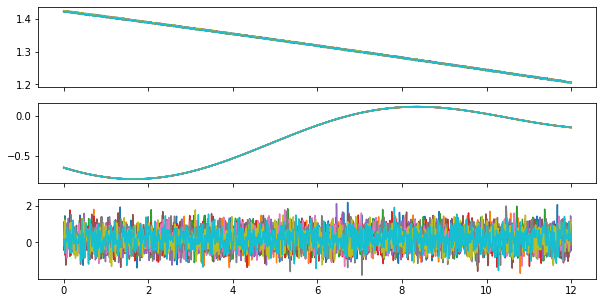

In [15]:
f, axes = plt.subplots(3, 1, sharex=True, figsize=(10, 5))
for i in range(3):
    for s in range(samples.shape[0]):
        axes[i].plot(Xstar, samples[s,:,i])
plt.show()